# Imports

In [16]:
import os 
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt

<br>

# Explanation

This data splitter will explore the spurious correlation that might arise between right and left eye images for a certain severity level. If the model was trained only on right-eye images with non-referrable severity levels (0 and 1) images and tested on right-eye images with referrable severity levels (2 to 4), there are two possible outcomes. If the model learns the spurious relationship between the side of the eye and the severity it will classify the test samples with lower severity scores. If the model is robust enough to the spurious correlation it will most probably classify the test images correctly regardless of the eye-side bias introduced in the data split.

<br>

# Common Functions

In [4]:
def detect_image_extension(image_folder):
    IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp')
    image_paths = glob(f'{image_folder}/**/**')
    assert len(image_paths), 'The images folder is empty! Please correct the folder path.'
    extension = os.path.splitext(image_paths[0])[-1]
    assert extension in IMG_EXTENSIONS, 'The images folder must only contain images files with consistent format.'
    return extension

<br>

# Definitions

In [5]:
# Path to image folder
IMG_FOLDER = '../datasets/reduced_eyepacs_resized_cropped'
# Path to the file containing the image labels
IMG_LABELS_FILE = '../datasets/reduced_eyepacs_resized_cropped/trainLabels_cropped.csv'
IMAGE_EXT = detect_image_extension(IMG_FOLDER)
SEED = 100

In [9]:
def get_dataset_with_metadata(df):
    df_img_info = df.copy()
    # Separates the patient ID from the eye-side information
    image_name_info = df_img_info['image'].str.split('_', expand=True)
    image_name_info.columns = ['patient_id', 'side']
    df_img_info = pd.concat([image_name_info, df_img_info], axis=1)
    df_img_info['image']  = df_img_info['level'].astype('str') + '/' + df_img_info['image'] + IMAGE_EXT
    # Referrable and non-referrable levels
    df_img_info['level_group'] = df_img_info['level'].map(lambda val: 'nref' if val <= 1 else 'ref')
    df_img_info['groups'] = df_img_info['side'] + '_' + df_img_info['level_group']
    return df_img_info

<br>

# Splitting data based on eye side, severity and frequency

## Preparing useful informationm

In [10]:
# Reading the labels data
df_labels = pd.read_csv(IMG_LABELS_FILE)
df_labels = df_labels[['image', 'level']]
# The image info will gather the useful information for splitting
df_img_info = get_dataset_with_metadata(df_labels)


# Handling Data Imbalance

In [14]:
label_count = df_img_info['level'].value_counts()

In [38]:
for patch in countplot.patches:
    print(patch.get_bbox().x0)

0.0
0.0
0.0
0.0
0.0


In [30]:
countplot.patches[0].get_bbox()

Bbox([[0.0, -0.4], [25802.0, 0.4]])

In [45]:
countplot.get_position()

Bbox([[0.125, 0.10999999999999999], [0.9, 0.88]])

In [52]:
label_count.iloc[0] + 500

26302

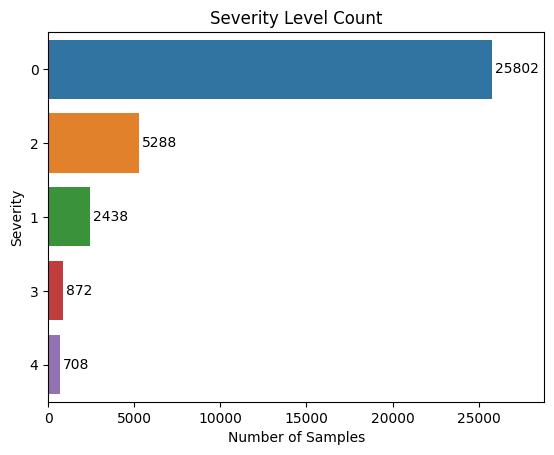

In [67]:
#fig, axes = plt.subplots(nrows=1, ncols=2)
plt.figure()
countplot = sns.countplot(y=df_img_info['level'], order=label_count.index)
countplot.bar_label(countplot.containers[0], padding=2)
plt.title('Severity Level Count')
plt.xlabel('Number of Samples')
plt.xlim(0, label_count.iloc[0] + 3e3)
plt.ylabel('Severity')
plt.show()

In [20]:
countplot.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                   ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

NameError: name 'bar' is not defined

In [11]:
df_img_info

,patient_id,side,image,level,level_group,groups
0,10,left,0/10_left.jpeg,0,nref,left_nref
1,10,right,0/10_right.jpeg,0,nref,right_nref
2,13,left,0/13_left.jpeg,0,nref,left_nref
3,13,right,0/13_right.jpeg,0,nref,right_nref
4,15,left,1/15_left.jpeg,1,nref,left_nref
...,...,...,...,...,...,...
35103,44347,right,0/44347_right.jpeg,0,nref,right_nref
35104,44348,left,0/44348_left.jpeg,0,nref,left_nref
35105,44348,right,0/44348_right.jpeg,0,nref,right_nref
35106,44349,left,0/44349_left.jpeg,0,nref,left_nref


In [59]:
df_img_info.groups.value_counts(normalize=True)

right_nref    0.403555
left_nref     0.400820
left_ref      0.099009
right_ref     0.096616
Name: groups, dtype: float64

## Splitting Images

First, we need to first define two important sets, the environment set $\mathcal{E}$ and the labels set $\mathcal{Y}$

$$
\large \mathcal{E} = \{left,\;right\}
$$

$$
\large \mathcal{Y} = \{nref,\; ref\}\; 
$$

$where:$
\begin{equation*}    
    \begin{aligned}
        &nref = \{0,1\}\\
        &ref = \{2,3,4\}
    \end{aligned}
\end{equation*}

In [61]:
MAJORITY_TRAIN_GROUPS = ['left_nref', 'right_ref']
MAJORITY_PROPORTION = 0.9
VAL_PCT_FROM_TRAIN = 0.1

In [62]:
df_major_groups_train = df_img_info.loc[df_img_info.groups.isin(MAJORITY_TRAIN_GROUPS)]

In [63]:
df_minor_groups_train = df_img_info.loc[df_img_info.index.difference(df_major_groups_train.index)]

In [64]:
majority_train, minority_test = train_test_split(
    df_major_groups_train, 
    stratify=df_major_groups_train['groups'], 
    train_size=MAJORITY_PROPORTION,
    random_state=SEED)

In [65]:
minority_train_size = round((len(majority_train) / MAJORITY_PROPORTION) * (1 - MAJORITY_PROPORTION))

In [66]:
majority_test, minority_train = train_test_split(
    df_minor_groups_train, 
    stratify=df_minor_groups_train['groups'], 
    test_size=minority_train_size / len(df_minor_groups_train),
    random_state=SEED)

In [67]:
# Taking part of training for validation
train_images = pd.concat([majority_train, minority_train], axis=0, sort=True)

In [68]:
train_images, val_images = train_test_split(
    train_images, 
    stratify=train_images['groups'],
    test_size=VAL_PCT_FROM_TRAIN,
    random_state=SEED)

In [69]:
test_images = pd.concat([majority_test, minority_test], axis=0, sort=True)

In [70]:
# Group distribution
print(f'Train:')
pprint(train_images['groups'].value_counts(normalize=True).round(decimals=2).to_dict())
print(f'Validation:')
pprint(val_images['groups'].value_counts(normalize=True).round(decimals=2).to_dict())
print(f'Test:')
pprint(test_images['groups'].value_counts(normalize=True).round(decimals=2).to_dict())

Train:
{'left_nref': 0.73, 'left_ref': 0.02, 'right_nref': 0.08, 'right_ref': 0.17}
Validation:
{'left_nref': 0.73, 'left_ref': 0.02, 'right_nref': 0.08, 'right_ref': 0.18}
Test:
{'left_nref': 0.08, 'left_ref': 0.18, 'right_nref': 0.72, 'right_ref': 0.02}


In [71]:
# Group total samples
print(f'Train:')
pprint(train_images['groups'].value_counts().round(decimals=2).to_dict())
print(f'Validation:')
pprint(val_images['groups'].value_counts().round(decimals=2).to_dict())
print(f'Test:')
pprint(test_images['groups'].value_counts().round(decimals=2).to_dict())

Train:
{'left_nref': 11397, 'left_ref': 310, 'right_nref': 1262, 'right_ref': 2747}
Validation:
{'left_nref': 1267, 'left_ref': 34, 'right_nref': 140, 'right_ref': 306}
Test:
{'left_nref': 1408, 'left_ref': 3132, 'right_nref': 12766, 'right_ref': 339}


<br>

# Saving outputs splits

In [72]:
metadata = df_img_info

In [73]:
# Transforming to relative image path from the dataset folder
metadata['image'] = metadata['image'].str.replace('../datasets/', '', regex=False)

In [74]:
metadata['split'] = np.nan

In [75]:
# Training set
metadata.loc[train_images.index, 'split'] = 'train'

In [76]:
# Validation set
metadata.loc[val_images.index, 'split'] = 'val'

In [77]:
# Test set
metadata.loc[test_images.index, 'split'] = 'test'

In [78]:
metadata

,patient_id,side,image,level,level_group,groups,split
0,10,left,0/10_left.jpeg,0,nref,left_nref,val
1,10,right,0/10_right.jpeg,0,nref,right_nref,test
2,13,left,0/13_left.jpeg,0,nref,left_nref,train
3,13,right,0/13_right.jpeg,0,nref,right_nref,test
4,15,left,1/15_left.jpeg,1,nref,left_nref,test
...,...,...,...,...,...,...,...
35103,44347,right,0/44347_right.jpeg,0,nref,right_nref,test
35104,44348,left,0/44348_left.jpeg,0,nref,left_nref,train
35105,44348,right,0/44348_right.jpeg,0,nref,right_nref,test
35106,44349,left,0/44349_left.jpeg,0,nref,left_nref,train


In [79]:
OUTPUT_PATH = os.path.join(IMG_FOLDER, 'metadata.csv')
df_img_info.to_csv(OUTPUT_PATH, index=False)

<br>